In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


three parts: 
- table detection & cell recognition with OpenCV
- allocate cell
- OCR with pytesseract



**recognize and fix broken lines in table recognition**

Link: https://towardsdatascience.com/how-to-recognize-and-fix-broken-lines-in-table-recognition-1a19f22d59f2

In [2]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=c963572a9ff87bc3e04731dee3a920d626a204cee74965b3e951099e283e00c9
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [3]:
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import csv
try: 
    from PIL import Image
except ImportError:
    import Image
import pytesseract

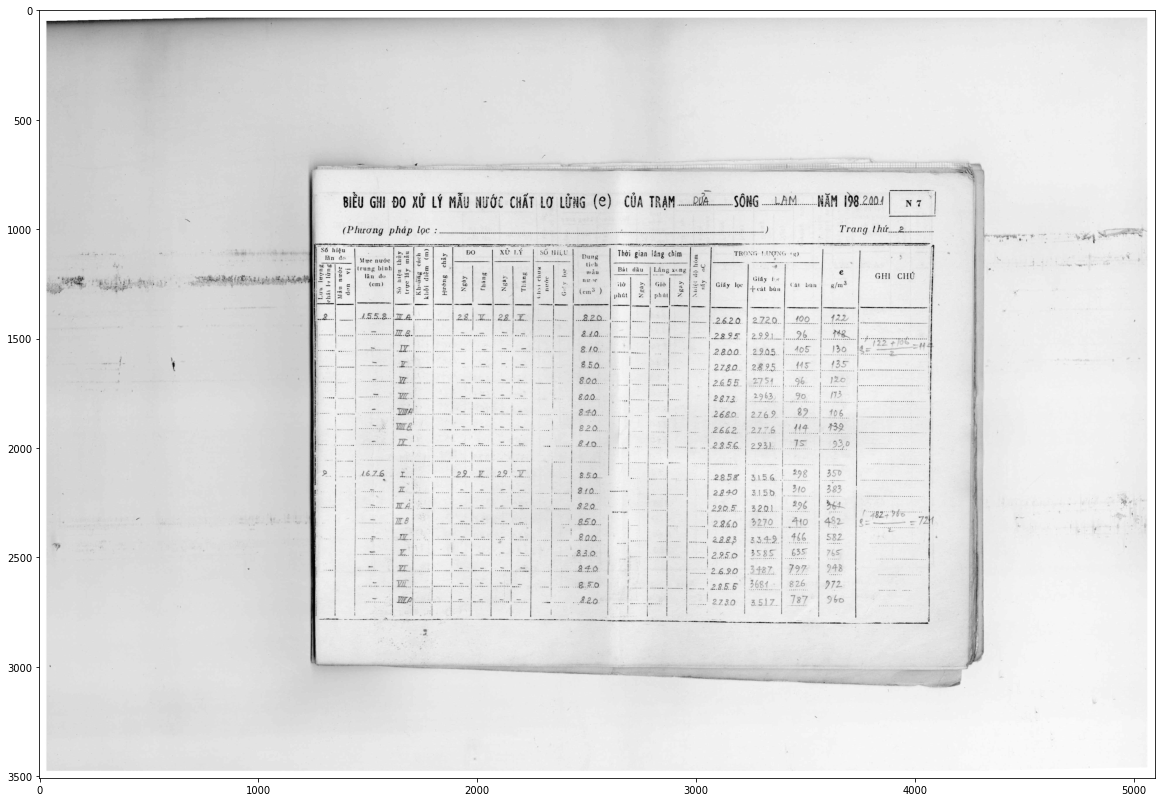

In [31]:
#convert input img to binary img (black background, white lines)
file = r'/content/drive/MyDrive/CV-VBD/data-test/6_Rlolung.pdf.jpg'
img = cv2.imread(file, 0)
#plot
plt.figure(figsize = (20,20))
plotting =plt.imshow(img, cmap = 'gray')
plt.show()

In [5]:
img.shape

(3508, 5100)

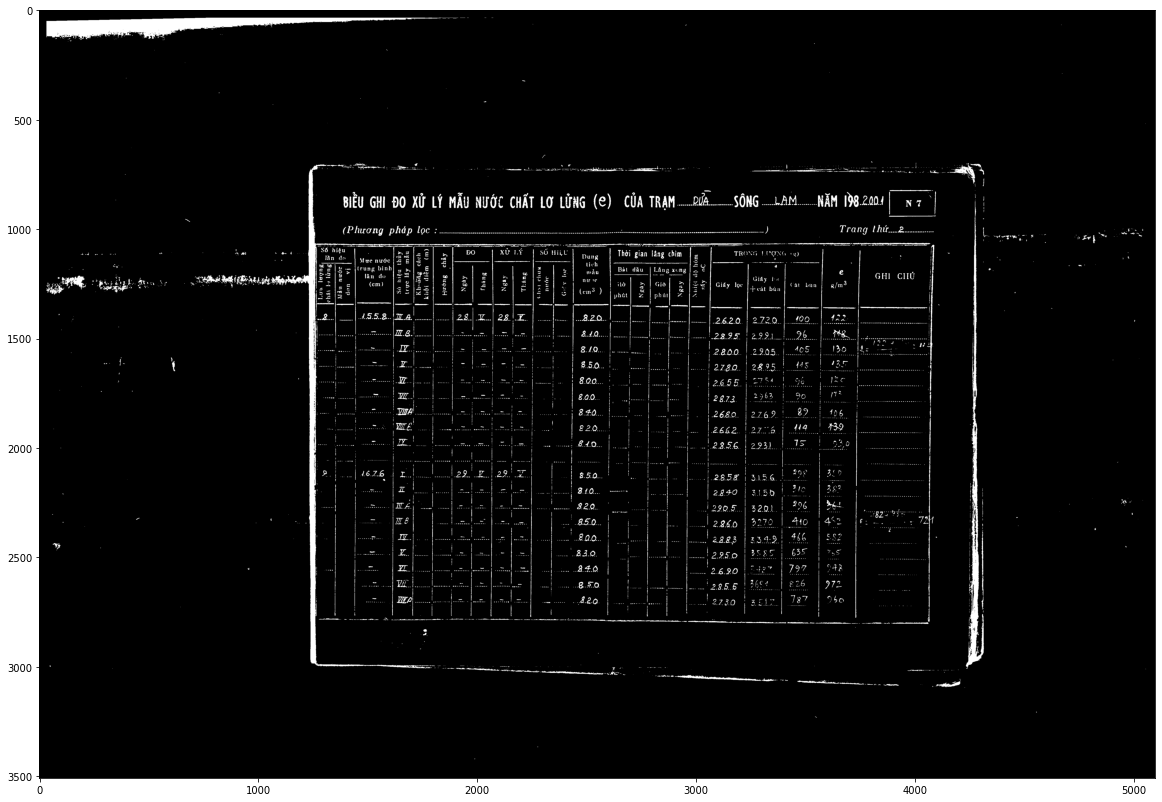

In [6]:

#threshold
thresh, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)

#inverting the image
img_bin = 255- img_bin
cv2.imwrite('/content/drive/MyDrive/CV-VBD/data-test/6_Rlolung.pdf_inverted.jpg', img_bin)
#plot
plt.figure(figsize = (20,20))
plotting = plt.imshow(img_bin, cmap = "gray")
plt.show()

In [25]:
#define kernel to detect box
#length (width) of kernel as 100th of total width
kernel_len = 40
#define a vertical kernel to detect all vertical lines of images
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))

#define a horizontal kernel to detect all horizontal lines of images
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len,1 ))
#A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))


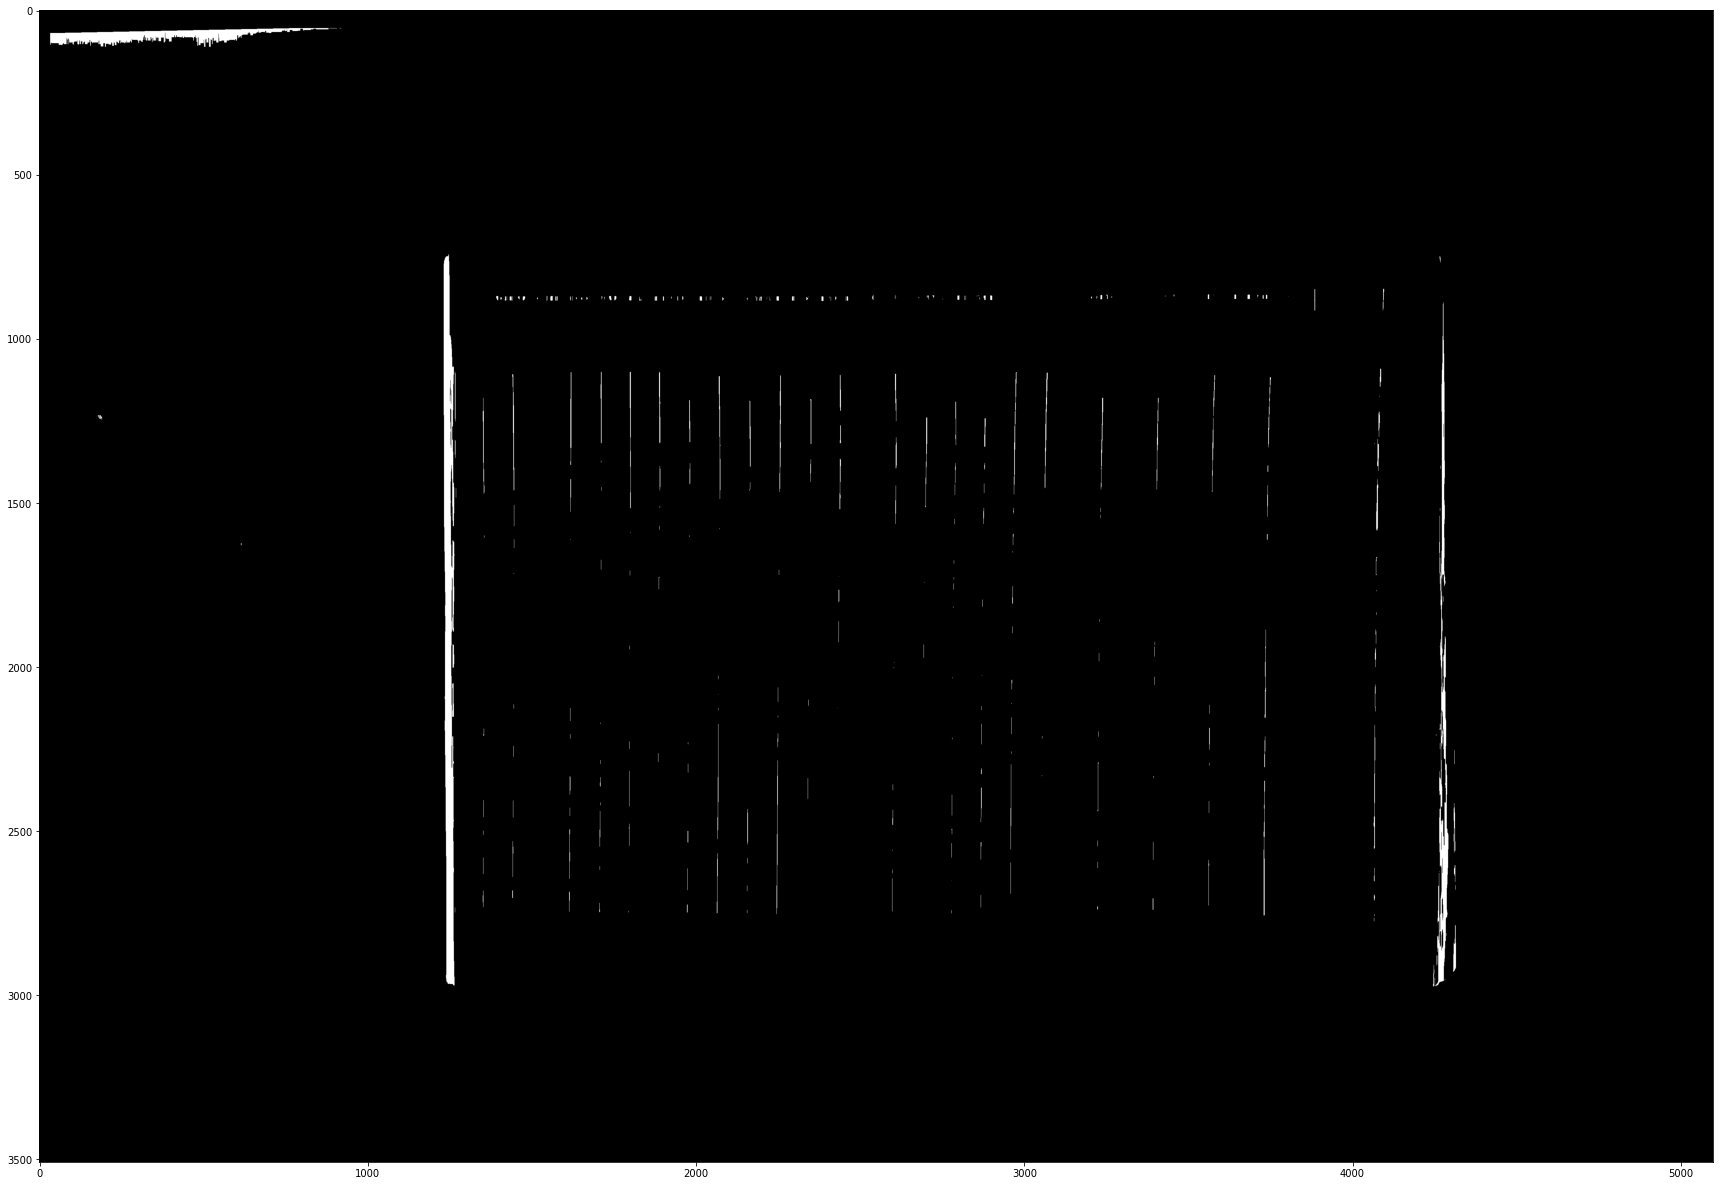

In [26]:
#use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations = 1)
vertical_lines =cv2.dilate(image_1, ver_kernel, iterations = 1)
cv2.imwrite('/content/drive/MyDrive/CV-VBD/data-test/6_Rlolung.pdf/vertical.jpg', vertical_lines)
#plot
plt.figure(figsize = (30, 30))
plotting = plt.imshow(image_1, cmap = "gray")
plt.show()

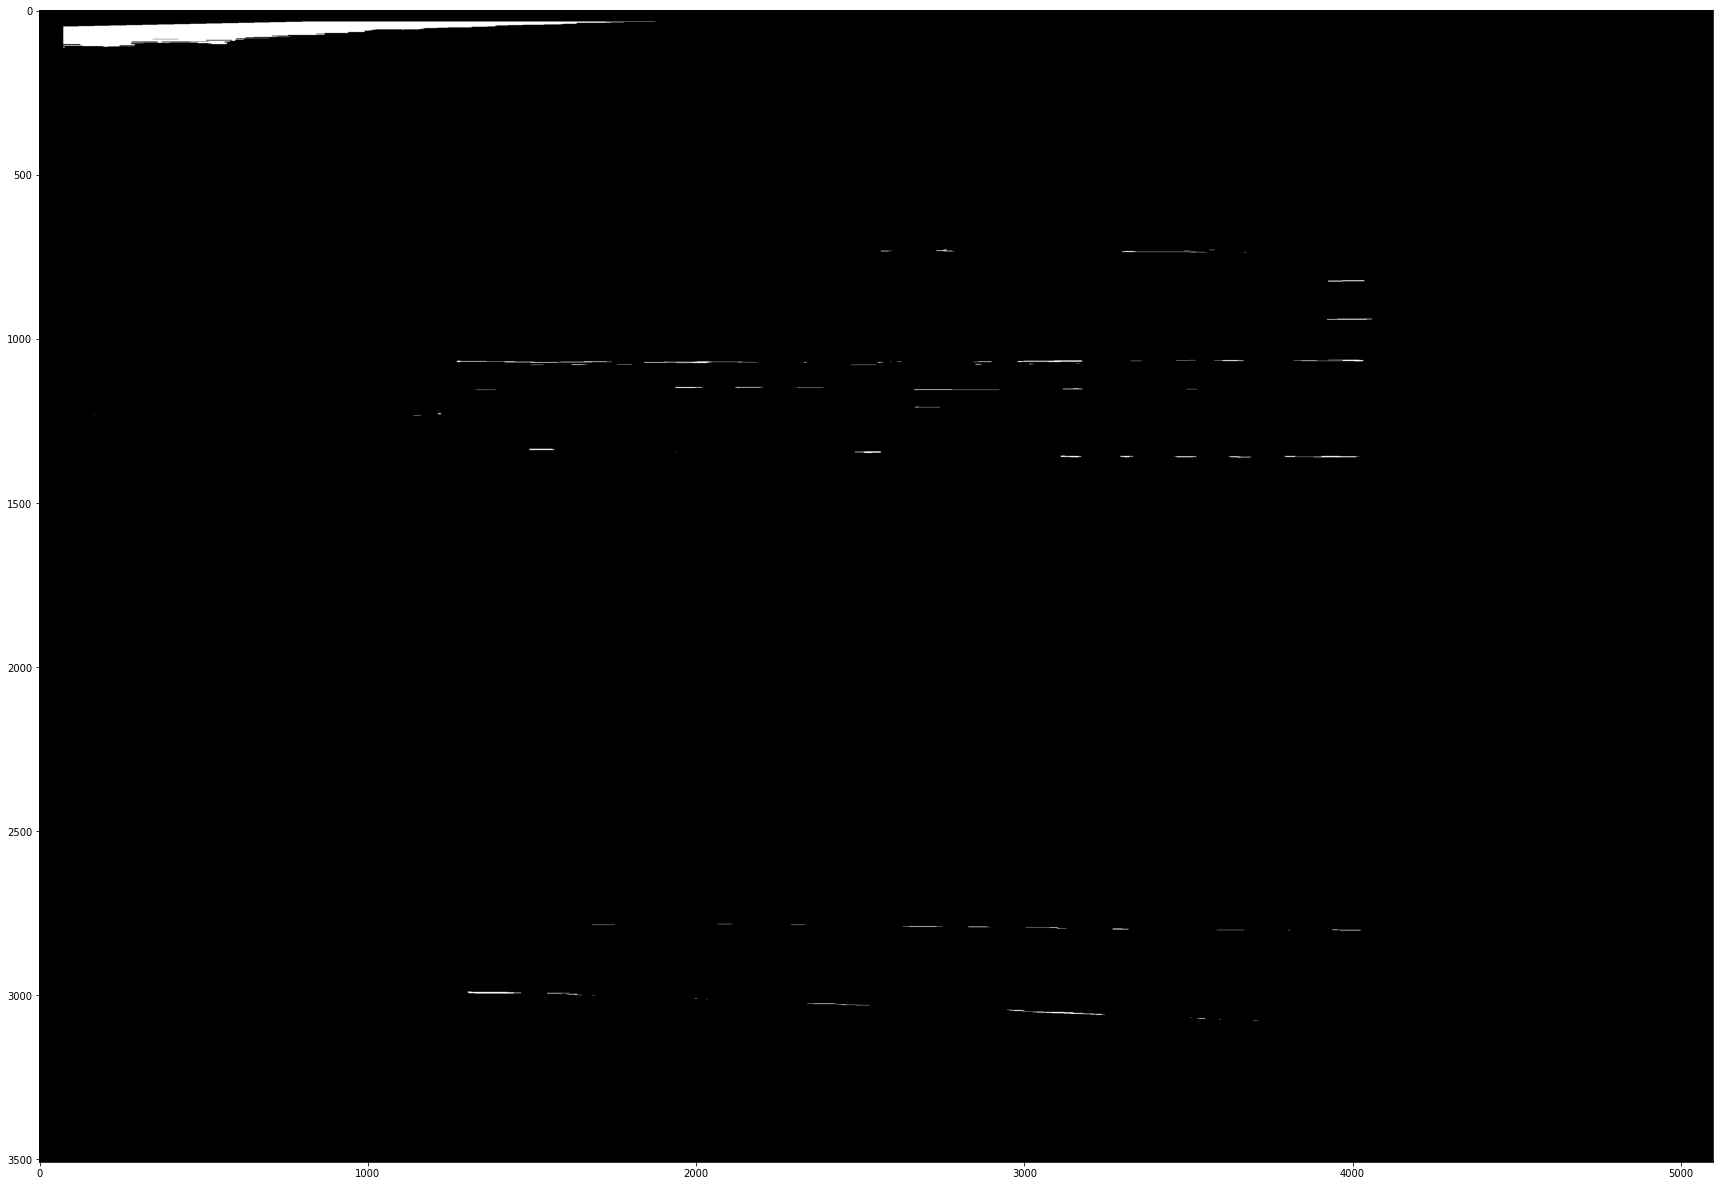

In [28]:
#use horizontal kernel to detect and save the horizontal lines in a jpg
horizontal_lines = cv2.erode(img_bin, hor_kernel, iterations = 2)
# horizontal_lines =cv2.dilate(image_1, hor_kernel, iterations =3)
cv2.imwrite('/content/drive/MyDrive/CV-VBD/6_SKT1.Thanh Hoa.pdf/horizontal.jpg', horizontal_lines)
#plot
plt.figure(figsize = (30,30))
plotting = plt.imshow(horizontal_lines, cmap = "gray")
plt.show()

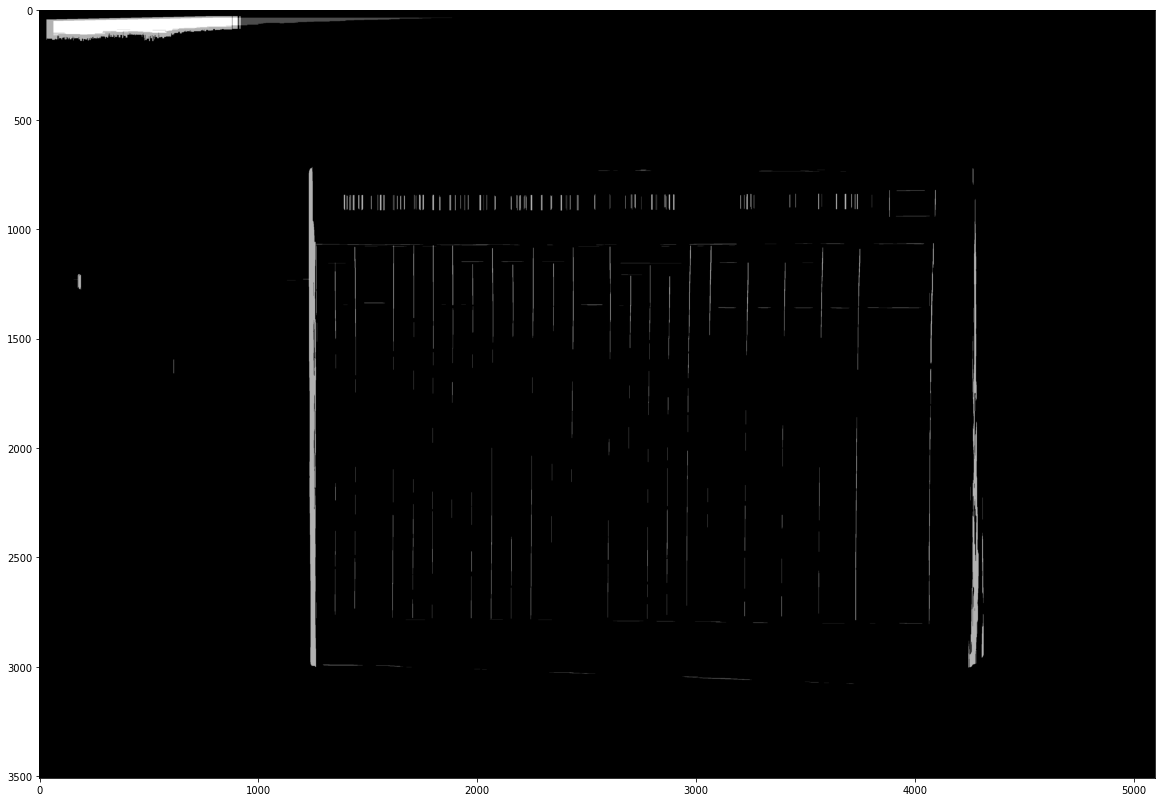

In [29]:
#combine hor & ver lines in a new img,


kernel_len = 10
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
vertical_lines1 = cv2.dilate(vertical_lines, kernel, iterations=2)


kernel_len = 10
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
horizontal_lines1 = cv2.dilate(horizontal_lines, kernel, iterations=2)

img_vh = cv2.addWeighted(vertical_lines1, 0.7, horizontal_lines1, 0.3, 0.0)

#eroding and thresholding the img
# img_vh = cv2.erode(img_vh, kernel, iterations=2)
# thres, img_vh = cv2.threshold(img_vh, 128, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
# cv2.imwrite("/content/drive/MyDrive/CV-VBD/2_BKT 11a.Thanh Hoa.pdf/img_vh.jpg", img_vh)

# bitxor  = cv2.bitwise_xor(img, img_vh)
# bitnot = cv2.bitwise_not(bitxor)

#plot
plt.figure(figsize = (20,20))
plotting = plt.imshow(img_vh, cmap ="gray")
plt.show()

In [30]:
#use findContours function to detect the contours >> extract coordinates of each box
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [15]:
def sort_contours(cnts, method = "left-to-right"):
    #initialize the reverse flag and sort index
    reverse = False
    i =0
    #handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    #handle if we are sorting against the y-coor rather than th x-coor of the bounding box
    if method == "top-to-bottom" or method =="bottom-to-top":
        i=1
    #construct the list of bounding box and sort them from top to bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key =lambda b:b[1][i], reverse=reverse))
    #return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

#Sort all the contours by top to bottom 
contours, boundingBoxes = sort_contours(contours, method= "top-to-bottom")
    

In [16]:
# retrieve the cell position

#creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
#get mean of heights
mean = np.mean(heights)


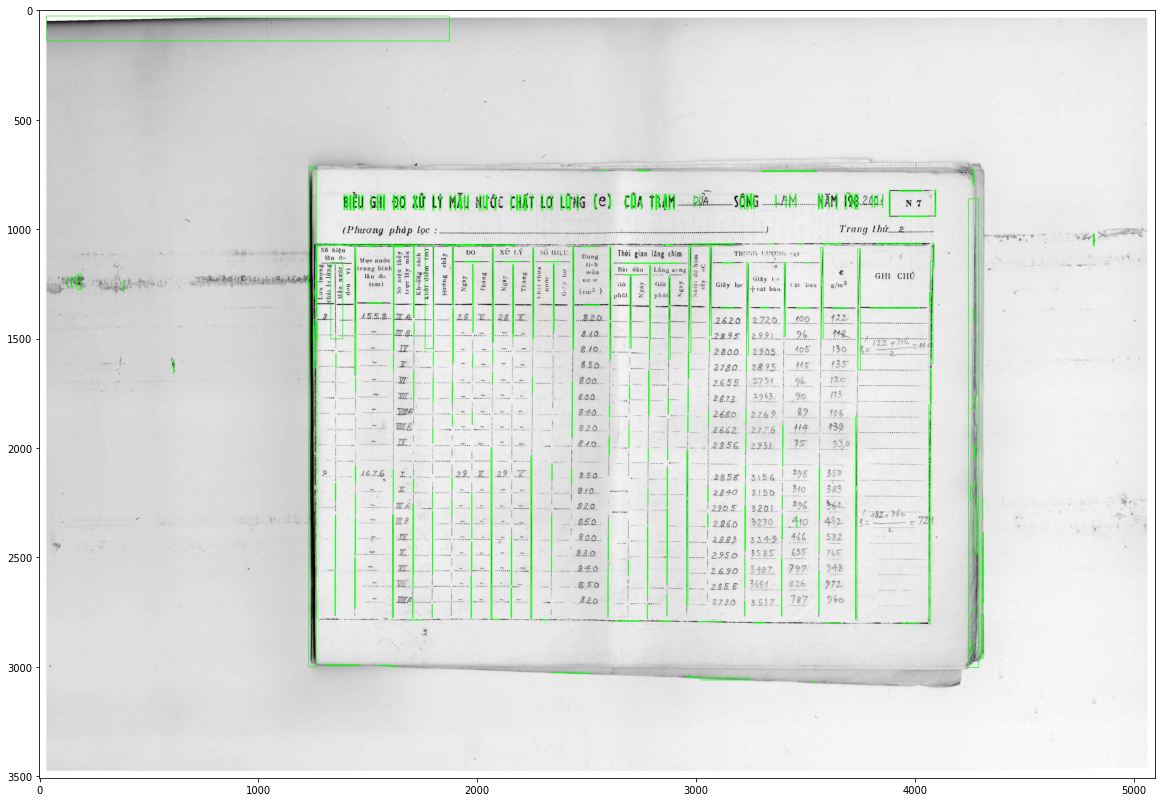

In [17]:
# create list box to store all boxes in 
box = []
#get position (x,y) width,height for every contour and show the contour on image
draw = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
for c in contours:
    x,y, w,h = cv2.boundingRect(c)
    if (w<3508 and h < 5100):
        draw = cv2.rectangle(draw, (x,y), (x+w, y+h), (0,255,0),2)
        box.append([x,y,w,h])
plt.figure(figsize = (20,20))
plotting = plt.imshow(draw)
plt.show()

In [18]:
# creating 2 list to define row & column in which cell is located
row = []
column =[]
j=0
#sorting the boxes to their respective row & col
for i in range(len(box)):
    if(i==0):
        column.append(box[i])
        previous = box[i]
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous =box[i]

            if(i==len(box)-1):
                row.append(column)
        else:
            row.append(column)
            column =[]
            previous = box[i]
            column.append(box[i])


print(column)
print(row)

[[4259, 2883, 5, 52], [4258, 2934, 3, 4], [1309, 2990, 157, 5], [1551, 2993, 61, 2], [1607, 2996, 30, 2], [2343, 3025, 86, 2], [2436, 3028, 55, 2], [2494, 3030, 35, 1], [2959, 3045, 41, 3], [2998, 3049, 21, 1], [3026, 3050, 219, 10], [3531, 3070, 19, 1]]
[[[34, 27, 1841, 114]], [[1232, 716, 34, 2284], [4267, 722, 3, 76], [2736, 732, 49, 3], [2568, 733, 27, 1], [3301, 734, 252, 4]], [[4094, 821, 4, 123], [3885, 822, 4, 122], [3930, 823, 105, 4], [3704, 832, 1, 57], [3682, 838, 7, 71], [3642, 838, 5, 71], [3561, 838, 4, 71], [3457, 838, 2, 63], [3738, 839, 4, 70], [3712, 839, 4, 65], [3576, 839, 2, 68], [3254, 839, 2, 70], [3251, 839, 2, 60], [2538, 839, 4, 73], [3728, 840, 3, 69], [3233, 840, 7, 70], [2608, 840, 1, 69], [2898, 841, 6, 71], [2878, 841, 6, 71], [2862, 841, 6, 71], [2798, 841, 6, 71], [2723, 841, 4, 66], [2721, 841, 1, 59], [2709, 841, 2, 70], [2705, 841, 2, 64], [3854, 842, 2, 58], [3429, 842, 4, 59], [2856, 842, 3, 62], [2823, 842, 1, 70], [2818, 842, 2, 70], [3806, 843,

In [19]:
#calculating maximum number of cells
cnt_col =0
for i in range(len(row)):
    cnt_col = len(row[i])
    if cnt_col > cnt_col: 
        cnt_col = cnt_col

In [20]:
#Retrieving the center of each column // lấy tâm của mỗi cột
center = [int(row[i][j][0]+ row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
center = np.array(center)
center.sort()

In [21]:
#khi này đã có box và giá trị box, các hàng có thể ko được sắp xếp đúng thứ tự 
finalboxes = []
for i in range(len(row)):
    lis = []
    for k in range(cnt_col):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center - (row[i][j][0] + row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

In [22]:
print(finalboxes)

[[[[34, 27, 1841, 114]], [], [], [], [], [], [], [], [], [], [], []], [[[1232, 716, 34, 2284]], [], [], [], [], [[2568, 733, 27, 1]], [[2736, 732, 49, 3]], [], [], [[3301, 734, 252, 4]], [], [[4267, 722, 3, 76]]], [[[1393, 843, 6, 70], [1474, 844, 7, 70], [1459, 844, 5, 66], [1440, 844, 2, 70], [1434, 844, 5, 69], [1419, 844, 4, 70], [1425, 845, 1, 68], [1406, 846, 4, 65]], [[1558, 843, 7, 71], [1549, 843, 1, 70], [1546, 843, 1, 71], [1578, 844, 2, 70], [1573, 844, 4, 70], [1516, 847, 4, 63]], [[1798, 843, 8, 71], [1752, 843, 7, 70], [1737, 843, 7, 70], [1714, 843, 3, 67], [1960, 844, 3, 68], [1945, 844, 2, 70], [1900, 844, 4, 70], [1876, 844, 7, 70], [1829, 844, 8, 70], [1624, 844, 1, 70], [1618, 844, 2, 69], [1925, 845, 3, 64], [1722, 845, 2, 66], [1919, 846, 1, 57], [1668, 846, 5, 65], [1650, 847, 5, 65], [1636, 847, 5, 63], [1930, 861, 1, 54]], [[2294, 843, 8, 71], [2384, 844, 6, 71], [2247, 844, 7, 70], [2182, 844, 4, 70], [2047, 844, 2, 67], [2043, 844, 2, 70], [2032, 844, 1, 70]

In [23]:
# import pytesseract
# !cd /content/drive/MyDrive/CV-VBD 

In [24]:
!pip install tesseract

     |████████████████████████████████| 45.6MB 100kB/s 
  Created wheel for tesseract: filename=tesseract-0.1.3-cp36-none-any.whl size=45562571 sha256=fef8234e533483d71e3023ccb331059f42eaa63852c885e4bc1f38961198a2b4
  Stored in directory: /root/.cache/pip/wheels/82/1f/d9/24797b123379e4ea9511cf660835468b62dad609634cad2aba
Successfully built tesseract


In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 15 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (3,406 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
#eroding and thresholding the img
img_vh = cv2.erode(img_vh, kernel, iterations=2)
thres, img_vh = cv2.threshold(img_vh, 128, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
cv2.imwrite("/content/drive/MyDrive/CV-VBD/2_BKT 11a.Thanh Hoa.pdf/img_vh.jpg", img_vh)

bitxor  = cv2.bitwise_xor(img, img_vh)
bitnot = cv2.bitwise_not(bitxor)


In [ ]:
!pip install imgaug==0.4.0

  Using cached https://files.pythonhosted.org/packages/66/b1/af3142c4a85cba6da9f4ebb5ff4e21e2616309552caca5e8acefe9840622/imgaug-0.4.0-py2.py3-none-any.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.5
    Uninstalling imgaug-0.2.5:
      Successfully uninstalled imgaug-0.2.5


In [ ]:
!pip install vietocr==0.2.1

     |████████████████████████████████| 51kB 2.6MB/s 
  Found existing installation: vietocr 0.3.2
    Uninstalling vietocr-0.3.2:
      Successfully uninstalled vietocr-0.3.2


In [ ]:
import vietocr

In [ ]:
!git clone https://github.com/pbcquoc/vietocr.git

Cloning into 'vietocr'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 3087 (delta 2), reused 0 (delta 0), pack-reused 3081
Receiving objects: 100% (3087/3087), 1.86 MiB | 16.73 MiB/s, done.
Resolving deltas: 100% (2304/2304), done.


In [ ]:
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [ ]:
config = Cfg.load_config_from_name('vgg_transformer')

In [ ]:

# config['weights'] = './weights/transformerocr.pth'
config['weights'] = 'https://drive.google.com/uc?id=13327Y1tz1ohsm5YZMyXVMPIOjoOA0OaA'
config['cnn']['pretrained']=False
config['device'] = 'cuda:0'
config['predictor']['beamsearch']=False

In [ ]:
detector = Predictor(config)

TypeError: ignored

In [ ]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner= " "
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

In [ ]:
print(outer)

[' ', ' ', ' ', ' ', ' ', ' ', '  \x0c', '  \x0c', ' ', '  \x0c \x0c', ' ', '  \x0c \x0c \x0c', ' ', '  \x0c', '  \x0c', '  \x0c', ' ', ' ', '  \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  \x0c', '  \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  \x0c', ' ', '  \x0c', '  \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '   \n\x0c', '   \n\x0c', '   \n\x0c', ' ', '  \x0c', '   \n\nYéu t6 | Tong eee Ces ae ee De | - Truc xa _ cece ce an ortne nl TT dia May\nio | Quan | _ yi eae cbs Be Bac Leg cakes ne Sree f acs eRe | Anbedo | _ mat troi} Luong Khi ap\n\nBU Pzey\n\n \n\n \n\n=\n\niis\n\n \n\n \n\n      \n  \n \n \n \n \n      \n  \n  \n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n  \n  \n   \n   \n\n   

In [ ]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner= " "
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)
                out = vietocr.image_to_string(erosion)
                    if(len(out)==0):
                        out = vietocr.image_to_string(erosion, config='--psm 3')
                    inner = inner +" "+ out
                outer.append(inner)    
            #     out = vietocr.image_to_string(erosion)
            #     if(len(out)==0):
            #         out = vietocr.image_to_string(erosion, config='--psm 3')
            #     inner = inner +" "+ out
            # outer.append(inner)

AttributeError: ignored

In [ ]:
print(outer)

[' ', ' ', ' ', ' ', ' ', ' ', '  \x0c', '  \x0c', ' ', '  \x0c \x0c', ' ', '  \x0c \x0c \x0c', ' ', '  \x0c', '  \x0c', '  \x0c', ' ', ' ', '  \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  \x0c', '  \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '  \x0c', ' ', '  \x0c', '  \x0c', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '   \n\x0c', '   \n\x0c', '   \n\x0c', ' ', '  \x0c', '  Seine\n\nroar Ho cae ry aa oe\n\n \n\n    \n\n \n\n    \n \n\nnq\n\nKhi ap\n1026]\n\ncre\n\nYN\n\n} o>\n\n   \n \n  \n \n    \n   \n  \n\nKe\n\n \n\n=)\nee)\n\n \n\n \n\n \n\n \n\n \n\nmp)\nao\n\n \n\n \n\n| }\n|\na\n\nie\nne aOggdc\n\ni)\nA)\n\n \n\n \n\n \n\noS\n~\n\n4 4 1\n\\} | |\n/\n. . o . .\nTPs Py | ‘|\n. .\n\n| Ox | 

In [ ]:
!pip install xlsxwriter

In [ ]:
#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),cnt_col))
print(dataframe)
data = dataframe.style.set_properties(align="left")

#Converting it in a excel-file
# data.to_excel("/content/drive/MyDrive/CV-VBD/2_BKT 11a.Thanh Hoa.pdf/output.xlsx")

In [ ]:
data.to_excel("output.xlsx", engine='xlsxwriter')